In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

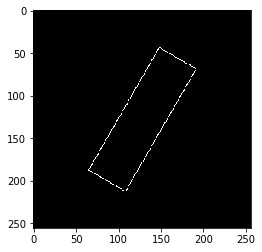

In [2]:
original = cv2.imread("sample-3.png")
plt.imshow(original)

peaks: 36 | extend peaks: 532 | rectangles: 4224


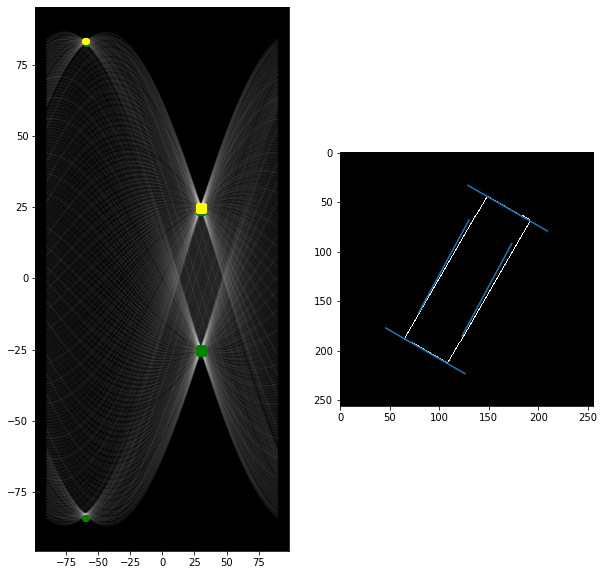

In [5]:
def polar_to_cortesian(r, t, c, half_width, half_height):
    a = np.cos(t)
    b = np.sin(t)
    x0 = a*r + half_width
    y0 = b*r + half_height
    x1 = int(x0 + c*(-b))
    y1 = int(y0 + c*(a))
    x2 = int(x0 - c*(-b))
    y2 = int(y0 - c*(a))
    return x1, y1, x2, y2
    

def rectangle_detection(num_thetas=500, num_rhos=500):
    #
    image = original.copy()
    edges = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge_height, edge_width = edges.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    image_diagonal = np.sqrt(np.square(edge_height) + np.square(edge_width))
    t_count = 45
    #
    figure = plt.figure(figsize=(10, 10))
    subplot1 = figure.add_subplot(1, 2, 1)
    subplot1.set_facecolor((0, 0, 0))
    subplot2 = figure.add_subplot(1, 2, 2)
    subplot2.imshow(image)
    #
    dtheta = 180 / num_thetas
    drho = 2 * image_diagonal / num_rhos
    thetas = np.arange(-90, 90, step=dtheta)
    rhos = np.arange(-image_diagonal, image_diagonal, step=drho)
    #
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    #
    edge_indexes = np.argwhere(edges > 0) - np.array([[edge_height_half, edge_width_half]])  # returns list of [y, x]
    rho_values = np.matmul(edge_indexes, np.array([sin_thetas, cos_thetas]))
    accumulator, theta_vals, rho_vals  = np.histogram2d(
        np.tile(thetas, rho_values.shape[0]),
        rho_values.ravel(),
        bins=[thetas, rhos]
    )
    accumulator = np.transpose(accumulator)
    #
    peaks = np.argwhere(accumulator > t_count)   
    rho_idxs, theta_idxs = peaks[:,0], peaks[:,1]
    r, t, c = rhos[rho_idxs], thetas[theta_idxs], accumulator[rho_idxs, theta_idxs]
    delta_t = np.abs(np.transpose([t]) - np.tile(t, (len(t), 1)))
    delta_r = np.abs(np.transpose([r]) + np.tile(r, (len(r), 1)))
    delta_c = np.abs(np.transpose([c]) - np.tile(c, (len(c), 1)))
    mid_point_c = (np.transpose([c]) + np.tile(c, (len(c), 1))) / 2
    #
    is_parrallel = delta_t < 3
    is_symmetric = delta_r < 3
    is_same_length = delta_c < mid_point_c * 0.4
    #
    peak_pairs = np.argwhere(np.logical_and(is_parrallel, is_symmetric, is_same_length) == True)
    pi_idx, pj_idx = peak_pairs[:,0], peak_pairs[:,1]
    pi, pj = peaks[pi_idx], peaks[pj_idx]
    rho_idxi, rho_idxj = pi[:,0], pj[:,0]
    theta_idxi, theta_idxj = pi[:,1], pj[:,1]
    ti, tj = thetas[theta_idxi], thetas[theta_idxj]
    ri, rj = rhos[rho_idxi], rhos[rho_idxj]
    alpha = (ti + tj) / 2
    epsilon = np.abs(ri - rj) / 2
    delta_alpha = np.abs(np.abs(np.transpose([alpha]) - np.tile(alpha, (len(alpha), 1))) - 90)
    is_orthogonal = delta_alpha < 3
    rectangles = np.argwhere(is_orthogonal)
    rectangle = rectangles[0]
    #
    pair1, pair2 = peak_pairs[rectangle[0]], peak_pairs[rectangle[1]]
    p1, p2, p3, p4 = peaks[pair1[0]], peaks[pair1[1]], peaks[pair2[0]], peaks[pair2[1]]
    r1, t1, c1 = rhos[p1[0]], thetas[p1[1]], accumulator[p1[0], p1[1]]
    r2, t2, c2 = rhos[p2[0]], thetas[p2[1]], accumulator[p2[0], p2[1]]
    r3, t3, c3 = rhos[p3[0]], thetas[p3[1]], accumulator[p3[0], p3[1]]
    r4, t4, c4 = rhos[p4[0]], thetas[p4[1]], accumulator[p4[0], p4[1]]
    x1_1, y1_1, x2_1, y2_1 = polar_to_cortesian(r1, np.deg2rad(t1), c1, edge_width_half, edge_height_half)
    x1_2, y1_2, x2_2, y2_2 = polar_to_cortesian(r2, np.deg2rad(t2), c2, edge_width_half, edge_height_half)
    x1_3, y1_3, x2_3, y2_3 = polar_to_cortesian(r3, np.deg2rad(t3), c3, edge_width_half, edge_height_half)
    x1_4, y1_4, x2_4, y2_4 = polar_to_cortesian(r4, np.deg2rad(t4), c4, edge_width_half, edge_height_half)
    #
    subplot2.add_line(mlines.Line2D([x1_1, x2_1], [y1_1, y2_1]))
    subplot2.add_line(mlines.Line2D([x1_2, x2_2], [y1_2, y2_2]))
    subplot2.add_line(mlines.Line2D([x1_3, x2_3], [y1_3, y2_3]))
    subplot2.add_line(mlines.Line2D([x1_4, x2_4], [y1_4, y2_4]))
    
    print(f"peaks: {len(peaks)} | extend peaks: {len(peak_pairs)} | rectangles: {len(rectangles)}")
    
    for row in rho_values:
        subplot1.plot(thetas, row, color="white", alpha=0.05)
    subplot1.plot([t], [r], color="green", marker='o')
    subplot1.plot([alpha], [epsilon], color="yellow", marker='o')
    plt.show()
    
rectangle_detection()